# 1. Notebook Dependencies

## Import libraries and modules

In [ ]:
import pandas as pd
import numpy as np 
import math
from math import sqrt
import matplotlib.pyplot as plt
import collections
import missingno as msno
import warnings

import seaborn as sns
warnings.filterwarnings("ignore")

#Machine Learning
import umap
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Import data from Fbref 

In [2]:
shooting = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Shooting_2022-04-26.csv")
possession = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Possession_2022-04-26.csv")
pass_types = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Pass Types_2022-04-26.csv")
passing = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Passing_2022-04-26.csv")
defense = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Defense_2022-04-26.csv")
miscellaneous = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Miscellaneous_22-04-27.csv")
creation = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/SCA GCA_2022-04-26.csv")
team = pd.read_csv("/Users/niklashemmer/Documents/Similar Player Tool/April/Team Possession_22-04-27.csv")

# 2. Data Cleaning

In [4]:
# Drop unnecessary columns to avoid duplicates when merging the dataframes
drop = [possession, pass_types, passing, defense, miscellaneous, creation]

for table in drop: 
    table.drop(["Rk", "Nation", "Pos", "Comp", "Age", "Born", "90s"], axis=1, inplace=True)

In [5]:
# Show all columns of dataframe
pd.set_option("display.max_columns", None)

In [6]:
# Merge dataframes and add "drop" for all duplicated columns
df = pd.merge(shooting, possession, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df = pd.merge(df, pass_types, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df = pd.merge(df, passing, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df = pd.merge(df, defense, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df = pd.merge(df, miscellaneous, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df = pd.merge(df, creation, how="left", on=["Player", "Season", "Squad"], suffixes=('', '_drop'))
df.shape

(13750, 153)

In [7]:
#Drop the duplicate columns
df.drop([col for col in df.columns if '_drop' in col], axis=1, inplace=True)

(13750, 148)

In [9]:
# Remove the ID behind the player name
df["Player"] = df["Player"].str.split("\\", expand=True)[0]

# Convert Age into an integer
df["Age"] = df["Age"].str.split("-", expand=True)[0]

# Split nation into two parts and use the latter 
df["Nation"] = df["Nation"].str.split(" ", expand=True)[1]

# Split competition into two parts and use the latter 
df["Comp"] = df["Comp"].str.split(" ", 1, expand=True)[1]

In [11]:
# Counts of missing values 
obj = df.isnull().sum()
for key, value in obj.iteritems():
    print(key,",",value)

Rk , 0
Player , 0
Season , 0
Nation , 3
Pos , 1
Squad , 0
Comp , 0
Age , 2
Born , 2
90s , 0
Gls , 0
Sh , 3
SoT , 0
SoT% , 2475
Sh/90 , 3
SoT/90 , 0
G/Sh , 2475
G/SoT , 4245
Dist , 2475
FK , 4
PK , 0
PKatt , 0
xG , 4
npxG , 4
npxG/Sh , 2475
G-xG , 4
np:G-xG , 4
Touches , 4
Touches Def Pen , 4
Touches Def 3rd , 4
Touches Mid 3rd , 4
Touches Att 3rd , 4
Touches Att Pen , 4
Touches Live , 4
Dribb Succ , 4
Dribb Att , 4
Dribb Succ% , 2057
Dribb #Pl , 4
Nutmegs , 4
Carries , 4
Carries TotDist , 4
Carries PrgDist , 4
Carries Prog , 4
Carries 1/3 , 4
Carries PA , 4
Mis , 4
Dis , 4
Rec Targ , 4
Rec Rec , 4
Rec Rec% , 67
Rec Prog , 4
Pass Att , 4
Pass Live , 4
Pass Dead , 4
TB , 4
Press Pass , 4
Pass Sw , 4
Crs , 3
Corner , 4
Corner In , 4
Corner Out , 4
Corner Str , 4
Ground Pass , 4
Low Pass , 4
High Pass , 4
Left Pass , 4
Right Pass , 4
Header , 4
TI , 4
Other , 4
Pass Comp , 4
Pass off , 4
Pass out , 4
Pass int , 4
Pass blo , 4
Pass Cmp , 4
Pass Cmp% , 72
Pass TotDist , 4
Pass PrgDist , 4
Sh

In [12]:
# Number of unique players 
len(df["Player"].unique())

5234

In [14]:
# Remove all Goalkeepers
df.drop(df[df["Pos"].str.contains("GK", na=False)].index, inplace=True)

In [ ]:
# Rename season (without df["Season"] = it would become a time series)
df["Season"] = df["Season"].replace(to_replace="2021/2022", value='21/22', regex=True)
df["Season"] = df["Season"].replace(to_replace="2020/2021", value='20/21', regex=True)
df["Season"] = df["Season"].replace(to_replace="2019/2020", value='19/20', regex=True)
df["Season"] = df["Season"].replace(to_replace="2018/2019", value='18/19', regex=True)
df["Season"] = df["Season"].replace(to_replace="2017/2018", value='17/18', regex=True)
df["Season"] = df["Season"].replace(to_replace="2016/2017", value='16/17', regex=True)

In [16]:
# Create seperate column for main position 
df["Main Pos"] = df["Pos"].str[0:2]
df.head()

,Rk,Player,Season,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,G/Sh,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Touches,Touches Def Pen,Touches Def 3rd,Touches Mid 3rd,Touches Att 3rd,Touches Att Pen,Touches Live,Dribb Succ,Dribb Att,Dribb Succ%,Dribb #Pl,Carries,Carries TotDist,Carries PrgDist,Carries Prog,Carries 1/3,Carries PA,Mis,Dis,Rec Targ,Rec Rec,Rec Rec%,Rec Prog,Pass Att,Pass Live,Pass Dead,TB,Press Pass,Pass Sw,Crs,Corner,Ground Pass,Low Pass,High Pass,Left Pass,Right Pass,Header,Pass Cmp,Pass Cmp%,Pass TotDist,Pass PrgDist,Short Pass Cmp,Short Pass Att,Short Pass Cmp%,Med Pass Cmp,Med Pass Att,Med Pass Cmp%,Long Pass Cmp,Long Pass Att,Long Pass Cmp%,Ast,xA,A-xA,KP,Pass 1/3,Pass PA,Crs PA,Pass Prog,Tkl,TklW,Tkl Def 3rd,Tkl Mid 3rd,Tkl Att 3rd,Dribb Tkl,Dribb Tkl Att,Dribb Tkl%,Dribb Past,Press,Press Succ,Press Succ %,Press Def 3rd,Press Mid 3rd,Press Att 3rd,Blocks,Sh block,Pass block,Int,Tkl+Int,Clr,Err,Fls,Fld,Recov,AerWon,AerLost,AerWon%,SCA,SCA90,SCA PassLive,SCA PassDead,SCA Drib,Main Pos
0,1,Max Aarons,2021/2022,ENG,DF,Norwich City,Premier League,22,2000.0,27.0,0.00,0.41,0.00,20.3,0.03,0.03,0.06,-0.03,-0.03,58.7,5.04,22.9,24.6,15.40,0.96,48.1,1.07,2.56,42.0,1.15,34.0,199.9,121.7,5.22,1.56,0.41,0.85,0.93,36.3,32.7,90.0,1.33,45.5,34.6,10.90,0.07,5.44,0.63,1.52,0.0,26.2,9.70,9.59,5.11,28.8,0.89,34.1,75.1,573.7,219.0,17.6,19.5,90.1,13.1,17.2,76.3,3.04,6.93,43.9,0.04,0.04,0.00,0.56,1.56,1.19,0.26,3.07,2.26,1.30,1.63,0.63,0.00,1.33,2.07,64.3,0.74,13.3,3.63,27.2,7.70,4.30,1.33,2.78,0.63,2.15,1.63,3.89,2.26,0.0,1.00,1.74,5.44,0.52,1.63,24.1,1.22,1.22,0.89,0.04,0.11,DF
1,2,Yunis Abdelhamid,2021/2022,MAR,DF,Reims,Ligue 1,34,1987.0,29.1,0.07,0.62,0.11,18.6,0.04,0.04,0.07,0.03,0.03,57.1,7.70,32.1,26.2,2.85,0.89,54.1,0.48,0.65,73.7,0.48,35.7,202.3,111.8,2.89,0.72,0.00,0.48,0.34,36.9,35.8,97.1,0.34,46.9,43.6,3.26,0.00,5.77,1.48,0.03,0.0,35.2,3.88,7.84,31.50,12.1,1.44,38.5,82.1,823.2,280.4,10.4,11.5,89.9,22.3,25.1,89.2,5.46,8.93,61.2,0.00,0.01,-0.01,0.21,2.41,0.17,0.00,2.65,1.72,1.24,1.20,0.48,0.03,0.38,0.82,45.8,0.45,13.5,4.71,34.8,7.66,5.05,0.82,1.82,0.72,1.10,3.13,4.85,3.13,0.0,1.37,0.79,7.08,2.10,1.37,60.4,0.62,0.62,0.38,0.00,0.10,DF
2,3,Salis Abdul Samed,2021/2022,GHA,MF,Clermont Foot,Ligue 1,22,2000.0,26.1,0.04,0.69,0.06,20.3,0.03,0.03,0.04,0.01,0.01,70.8,2.11,23.2,41.6,10.80,0.65,70.2,1.03,1.61,64.3,1.15,53.9,242.6,102.0,2.61,0.65,0.15,0.84,1.49,59.0,54.6,92.5,1.72,61.3,60.6,0.73,0.04,8.05,0.77,0.31,0.0,52.8,4.71,3.75,4.75,53.5,1.88,56.2,91.6,1040.9,185.1,22.6,24.2,93.5,26.0,27.5,94.7,6.82,7.93,86.0,0.00,0.04,-0.04,0.54,2.76,0.42,0.00,2.87,2.03,1.26,0.92,0.92,0.19,0.73,2.26,32.2,1.53,23.4,6.70,28.7,7.36,12.10,3.95,0.92,0.04,0.88,1.88,3.91,0.57,0.0,1.53,1.23,8.70,0.88,0.88,50.0,1.42,1.42,1.03,0.00,0.00,MF
3,4,Laurent Abergel,2021/2022,FRA,MF,Lorient,Ligue 1,29,1993.0,29.2,0.00,0.89,0.00,22.2,0.07,0.07,0.07,-0.07,-0.07,60.7,0.75,14.1,39.5,11.10,0.45,60.0,1.34,2.09,63.9,1.40,45.3,170.0,85.3,2.84,1.16,0.07,0.89,1.51,44.9,41.7,93.1,1.78,48.6,47.7,0.86,0.17,9.08,1.44,0.75,0.0,36.5,5.48,6.58,4.42,42.9,0.62,39.8,81.9,766.8,204.8,15.9,17.8,88.9,16.9,19.2,87.9,6.20,9.04,68.6,0.07,0.08,-0.01,0.72,3.87,0.58,0.21,4.04,3.70,2.33,1.51,1.85,0.34,1.85,4.79,38.6,2.95,27.6,7.81,28.3,9.42,14.90,3.32,1.68,0.10,1.58,2.67,6.37,0.38,0.0,1.47,2.16,9.08,0.41,0.45,48.0,1.85,1.85,1.30,0.07,0.00,MF
4,5,Charles Abi,2021/2022,FRA,FW,Saint-Étienne,Ligue 1,22,2000.0,0.5,0.00,0.00,NaN,NaN,0.00,0.00,NaN,0.00,0.00,24.0,0.00,0.0,10.0,18.00,6.00,24.0,0.00,0.00,NaN,0.00,18.0,118.0,18.0,0.00,2.00,0.00,8.00,0.00,24.0,16.0,66.7,4.00,12.0,12.0,0.00,0.00,6.00,0.00,2.00,0.0,10.0,0.00,2.00,12.00,0.0,0.00,4.0,33.3,48.0,0.0,2.0,4.0,50.0,2.0,6.0,33.3,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.0,2.00,28.0,2.00,7.1,0.00,22.00,6.00,2.00,0.00,2.00,0.00,0.00,0.00,0.0,2.00,0.00,4.00,2.00,0.00,100.0,0.00,0.00,0.00,0.00,0.00,FW


In [17]:
# Rename column in DataFrame about team data to allow merge with main DataFrame 
team = team.rename(columns={"Touches": "Team Touches"})

In [18]:
# Adding Posssesion Data to the DataFrame 
df = df.merge(team[["Season", "Squad", "Poss", "Team Touches", "Def Pen", "Def 3rd", "Mid 3rd", "Att 3rd", "Att Pen"]], how="left", on=["Season","Squad"])

df.head(2)

,Rk,Player,Season,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,G/Sh,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Touches,Touches Def Pen,Touches Def 3rd,Touches Mid 3rd,Touches Att 3rd,Touches Att Pen,Touches Live,Dribb Succ,Dribb Att,Dribb Succ%,Dribb #Pl,Carries,Carries TotDist,Carries PrgDist,Carries Prog,Carries 1/3,Carries PA,Mis,Dis,Rec Targ,Rec Rec,Rec Rec%,Rec Prog,Pass Att,Pass Live,Pass Dead,TB,Press Pass,Pass Sw,Crs,Corner,Ground Pass,Low Pass,High Pass,Left Pass,Right Pass,Header,Pass Cmp,Pass Cmp%,Pass TotDist,Pass PrgDist,Short Pass Cmp,Short Pass Att,Short Pass Cmp%,Med Pass Cmp,Med Pass Att,Med Pass Cmp%,Long Pass Cmp,Long Pass Att,Long Pass Cmp%,Ast,xA,A-xA,KP,Pass 1/3,Pass PA,Crs PA,Pass Prog,Tkl,TklW,Tkl Def 3rd,Tkl Mid 3rd,Tkl Att 3rd,Dribb Tkl,Dribb Tkl Att,Dribb Tkl%,Dribb Past,Press,Press Succ,Press Succ %,Press Def 3rd,Press Mid 3rd,Press Att 3rd,Blocks,Sh block,Pass block,Int,Tkl+Int,Clr,Err,Fls,Fld,Recov,AerWon,AerLost,AerWon%,SCA,SCA90,SCA PassLive,SCA PassDead,SCA Drib,Main Pos,Poss,Team Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen
0,1,Max Aarons,2021/2022,ENG,DF,Norwich City,Premier League,22,2000.0,27.0,0.00,0.41,0.00,20.3,0.03,0.03,0.06,-0.03,-0.03,58.7,5.04,22.9,24.6,15.40,0.96,48.1,1.07,2.56,42.0,1.15,34.0,199.9,121.7,5.22,1.56,0.41,0.85,0.93,36.3,32.7,90.0,1.33,45.5,34.6,10.90,0.07,5.44,0.63,1.52,0.0,26.2,9.70,9.59,5.11,28.8,0.89,34.1,75.1,573.7,219.0,17.6,19.5,90.1,13.1,17.2,76.3,3.04,6.93,43.9,0.04,0.04,0.00,0.56,1.56,1.19,0.26,3.07,2.26,1.30,1.63,0.63,0.00,1.33,2.07,64.3,0.74,13.3,3.63,27.2,7.70,4.30,1.33,2.78,0.63,2.15,1.63,3.89,2.26,0.0,1.00,1.74,5.44,0.52,1.63,24.1,1.22,1.22,0.89,0.04,0.11,DF,42.8,531.7,81.0,223.0,221.6,118.7,18.2
1,2,Yunis Abdelhamid,2021/2022,MAR,DF,Reims,Ligue 1,34,1987.0,29.1,0.07,0.62,0.11,18.6,0.04,0.04,0.07,0.03,0.03,57.1,7.70,32.1,26.2,2.85,0.89,54.1,0.48,0.65,73.7,0.48,35.7,202.3,111.8,2.89,0.72,0.00,0.48,0.34,36.9,35.8,97.1,0.34,46.9,43.6,3.26,0.00,5.77,1.48,0.03,0.0,35.2,3.88,7.84,31.50,12.1,1.44,38.5,82.1,823.2,280.4,10.4,11.5,89.9,22.3,25.1,89.2,5.46,8.93,61.2,0.00,0.01,-0.01,0.21,2.41,0.17,0.00,2.65,1.72,1.24,1.20,0.48,0.03,0.38,0.82,45.8,0.45,13.5,4.71,34.8,7.66,5.05,0.82,1.82,0.72,1.10,3.13,4.85,3.13,0.0,1.37,0.79,7.08,2.10,1.37,60.4,0.62,0.62,0.38,0.00,0.10,DF,41.9,531.7,69.4,210.8,240.2,116.4,17.6


In [19]:
# Adding colors to visualize UMAP graph later
color_list = []
for n in range(len(df)):
    if str(df['Main Pos'][n]) == 'DF':
        color_list.append("Red")
    elif str(df['Main Pos'][n]) == 'MF':
        color_list.append("Blue")
    else:
        color_list.append("Green")
        
df['Color'] = color_list

# 3. Data Engineering

## Adjust for possession

In [20]:
# Adjusting for Posssesion
df_poss_adj = ["Tkl", "TklW", "Tkl Def 3rd", "Tkl Mid 3rd", "Tkl Att 3rd",
              "Dribb Tkl", "Dribb Tkl Att", "Int", "Tkl+Int",
              "Clr", "Recov", "Blocks", "Sh block", "Pass block"]

for i in df_poss_adj: 
    df[i] = (df[i] * df["Poss"]/50).round(2)

# Re-calculate percentage numbers 
df["TklW %"] = ((df["TklW"] / df["Tkl"])*100).round(2)
df["Dribb Tkl%"] = (df["Dribb Tkl"] / df["Dribb Tkl Att"]*100).round(2)

## Add and adjust metrics

In [21]:
# Additional numbers (Note: only a fraction was ultimately used)
df["2nd KP"] = df["SCA PassLive"] + df["SCA PassDead"] - df["KP"]
df["Turnover"] = df["Mis"] + (df["Dribb Att"] - df["Dribb Succ"])
df["Two Footed"] = df["Left Pass"] / df["Right Pass"]
df["Sh/Touch"] = df["Sh"]/df["Touches"]
df["Crosses Succ %"] = (df["Crs PA"]/df["Crs"]*100).round(2)
df["Aer"] = df["AerWon"] + df["AerLost"]
df["1/3 Entry"] = df["Carries 1/3"] + df["Pass 1/3"]
df["PA"] = df["Pass PA"] + df["Carries PA"]

In [22]:
# Scale area touches by proportion of overall touches (Note: only a fraction was ultimately used)
df_touches_scale = ["Touches Def Pen", "Touches Def 3rd", "Touches Mid 3rd", "Touches Att 3rd",
                   "Touches Att Pen"]
for i in df_touches_scale:
    df[i + " %"] = (df[i]/df["Touches"]*100).round(2)
    
    
df_tackles = ["Tkl Def 3rd", "Tkl Mid 3rd", "Tkl Att 3rd"]
for i in df_tackles:
    df[i + " %"] = (df[i]/df["Tkl"]*100).round(2)
    
# Scale metrics per 100 touches 
df_per100touches = ["Carries", "Dribb Succ", "Dribb Att", "Crs", "KP", "Pass Prog", "Crs PA", "Pass 1/3", "xA", "npxG",
                   "Carries PrgDist", "Carries Prog", "Carries 1/3", "Carries PA", "Pass PrgDist", "Pass PA", "Fls", 
                    "Fld", "Rec Prog", "Pass Sw", "TB", "1/3 Entry", "Turnover", "PA", "Pass Att", "Aer", "SCA90"]
for i in df_per100touches:
    df[i + "_p100T"] = (df[i]/df["Touches"]*100).round(2)

# Scale Progressive Pass Distance and Progressive Carry Distance
df["Carries PrgDist %"] = ((df["Carries PrgDist"] / df["Carries TotDist"])*100).round(2)
df["Pass PrgDist %"] = ((df["Pass PrgDist"] / df["Pass TotDist"])*100).round(2)

# Average carry and progressive pass length 
df["Avg Prog Carry"] = df["Carries PrgDist"]/df["Carries Prog"]
df["Avg Prog Pass"] = df["Pass PrgDist"]/df["Pass Prog"]
df["Avg Pass Length"] = df["Pass TotDist"]/df["Pass Cmp"]

# Percentage of team Touches
df["% Team Touches"] = df["Touches"] / df["Team Touches"]
df["% Team Touches_Def Pen"] = df["Touches Def Pen"] / df["Def Pen"]
df["% Team Touches_Def 3rd"] = df["Touches Def 3rd"] / df["Def 3rd"]
df["% Team Touches_Mid 3rd"] = df["Touches Mid 3rd"] / df["Mid 3rd"]
df["% Team Touches_Att 3rd"] = df["Touches Att 3rd"] / df["Att 3rd"]
df["% Team Touches_Att Pen"] = df["Touches Att Pen"] / df["Att Pen"]

## Create ID column

In [24]:
# Create new ID column 
df["ID"] = df["Player"] + " (" + df["Squad"] + " " + df["Season"] + ")"

# Drop rank column 
df.drop("Rk", axis=1, inplace=True)

# Place ID as first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

## Subset DataFrame

In [25]:
# Subset the data for all players with more than 900 minutes 
df_all = df[df["90s"] > 10]
len(df_all)
df.head(1)

,ID,Player,Season,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,G/Sh,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Touches,Touches Def Pen,Touches Def 3rd,Touches Mid 3rd,Touches Att 3rd,Touches Att Pen,Touches Live,Dribb Succ,Dribb Att,Dribb Succ%,Dribb #Pl,Carries,Carries TotDist,Carries PrgDist,Carries Prog,Carries 1/3,Carries PA,Mis,Dis,Rec Targ,Rec Rec,Rec Rec%,Rec Prog,Pass Att,Pass Live,Pass Dead,TB,Press Pass,Pass Sw,Crs,Corner,Ground Pass,Low Pass,High Pass,Left Pass,Right Pass,Header,Pass Cmp,Pass Cmp%,Pass TotDist,Pass PrgDist,Short Pass Cmp,Short Pass Att,Short Pass Cmp%,Med Pass Cmp,Med Pass Att,Med Pass Cmp%,Long Pass Cmp,Long Pass Att,Long Pass Cmp%,Ast,xA,A-xA,KP,Pass 1/3,Pass PA,Crs PA,Pass Prog,Tkl,TklW,Tkl Def 3rd,Tkl Mid 3rd,Tkl Att 3rd,Dribb Tkl,Dribb Tkl Att,Dribb Tkl%,Dribb Past,Press,Press Succ,Press Succ %,Press Def 3rd,Press Mid 3rd,Press Att 3rd,Blocks,Sh block,Pass block,Int,Tkl+Int,Clr,Err,Fls,Fld,Recov,AerWon,AerLost,AerWon%,SCA,SCA90,SCA PassLive,SCA PassDead,SCA Drib,Main Pos,Poss,Team Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen,Color,TklW %,2nd KP,Turnover,Two Footed,Sh/Touch,Crosses Succ %,Aer,1/3 Entry,PA,Touches Def Pen %,Touches Def 3rd %,Touches Mid 3rd %,Touches Att 3rd %,Touches Att Pen %,Tkl Def 3rd %,Tkl Mid 3rd %,Tkl Att 3rd %,Press Def 3rd %,Press Mid 3rd %,Press Att 3rd %,Carries_p100T,Dribb Succ_p100T,Dribb Att_p100T,Crs_p100T,KP_p100T,Pass Prog_p100T,Crs PA_p100T,Pass 1/3_p100T,xA_p100T,npxG_p100T,Carries PrgDist_p100T,Carries Prog_p100T,Carries 1/3_p100T,Carries PA_p100T,Pass PrgDist_p100T,Pass PA_p100T,Fls_p100T,Fld_p100T,Rec Prog_p100T,Pass Sw_p100T,TB_p100T,1/3 Entry_p100T,Turnover_p100T,PA_p100T,Pass Att_p100T,Aer_p100T,SCA90_p100T,Press Pass %,Pass Sw %,Short Pass Att %,Med Pass Att %,Long Pass Att %,Pass Dead %,Carries PrgDist %,Pass PrgDist %,Avg Prog Carry,Avg Prog Pass,Avg Pass Length,% Team Touches,% Team Touches_Def Pen,% Team Touches_Def 3rd,% Team Touches_Mid 3rd,% Team Touches_Att 3rd,% Team Touches_Att Pen
0,Max Aarons (Norwich City 21/22),Max Aarons,21/22,ENG,DF,Norwich City,Premier League,22,2000.0,27.0,0.0,0.41,0.0,20.3,0.03,0.03,0.06,-0.03,-0.03,58.7,5.04,22.9,24.6,15.4,0.96,48.1,1.07,2.56,42.0,1.15,34.0,199.9,121.7,5.22,1.56,0.41,0.85,0.93,36.3,32.7,90.0,1.33,45.5,34.6,10.9,0.07,5.44,0.63,1.52,0.0,26.2,9.7,9.59,5.11,28.8,0.89,34.1,75.1,573.7,219.0,17.6,19.5,90.1,13.1,17.2,76.3,3.04,6.93,43.9,0.04,0.04,0.0,0.56,1.56,1.19,0.26,3.07,1.93,1.11,1.4,0.54,0.0,1.14,1.77,64.41,0.74,13.3,3.63,27.2,7.7,4.3,1.33,2.38,0.54,1.84,1.4,3.33,1.93,0.0,1.0,1.74,4.66,0.52,1.63,24.1,1.22,1.22,0.89,0.04,0.11,DF,42.8,531.7,81.0,223.0,221.6,118.7,18.2,Red,57.51,0.37,2.34,0.177431,0.006985,17.11,2.15,3.12,1.6,8.59,39.01,41.91,26.24,1.64,72.54,27.98,0.0,57.89,32.33,10.0,57.92,1.82,4.36,2.59,0.95,5.23,0.44,2.66,0.07,0.05,207.33,8.89,2.66,0.7,373.08,2.03,1.7,2.96,2.27,1.07,0.12,5.32,3.99,2.73,77.51,3.66,2.08,11.96,1.38,42.86,37.8,15.23,23.96,60.88,38.17,23.314176,71.335505,16.824047,0.110401,0.062222,0.102691,0.111011,0.129739,0.052747


## Select columns for our clustering algorithm 

In [26]:
# Define Stats
cols_stats = ["% Team Touches",
              "Touches Def Pen %", 
              "Touches Def 3rd %", 
              "Touches Mid 3rd %", 
              "Touches Att 3rd %",
              "Touches Att Pen %",
              "Carries PrgDist_p100T", 
              "Carries Prog_p100T", 
              "Carries 1/3_p100T", 
              "Carries PA_p100T",
              "Pass PrgDist_p100T",
              "Pass 1/3_p100T",
              "Pass Prog_p100T",
              "Pass PA_p100T",
              "Dribb Att_p100T",
              "Avg Pass Length",
              "Crs_p100T", 
              "KP_p100T", 
              "Pass Sw_p100T",
              "Crs PA_p100T", 
              "Sh/Touch", 
              "Press Pass %", 
              "Short Pass Att %",
              "SCA90_p100T",
              "Med Pass Att %", 
              "Long Pass Att %",
              "Pass Cmp%",
              "Fls_p100T",
              "Fld_p100T",
              "Aer",
              "Turnover_p100T",
              "Rec Prog_p100T",    
              "npxG_p100T",
              "xA_p100T",
              #Defensive
              "Int", 
              "Dribb Tkl",
              "Clr",
              "Blocks",
              "Tkl",
              "Recov",
              "Tkl Def 3rd %", 
              "Tkl Mid 3rd %", 
              "Tkl Att 3rd %",
              "Press",
              "Press Def 3rd %", 
              "Press Mid 3rd %", 
              "Press Att 3rd %"
             ]

In [27]:
# Create a dataframe of numerical values 
df_all_stats = df_all[cols_stats]
df_all_stats.shape

(7307, 47)

In [28]:
# Replace NULL values 
df_all_stats.fillna(0, inplace=True)

## Standardize Data

Since GMM is a distance-based measurement, standardization should be applied to prevent outliers from skewing the measurements when we have different units and therefore different magnitudes of data. 

In [29]:
# Standardization
x = df_all_stats
scaler = StandardScaler()

# Fit and then transform the data 
x_scaled = scaler.fit_transform(x)
x_normed = pd.DataFrame(x_scaled)
##Option2
x[cols_stats] = scaler.fit_transform(x)

# 4. Clustering

The clustering is divdided into two parts:
1. UMAP to reduce the dimensionality of our data 
2. Gaussian Mixture Model (GMM) to create clusters 

## UMAP 

Our goal by using UMAP is to reduce the dimensionality of our data. This has several benefits. It makes the dataset easier to manage without losing much information as features are compressed into a smaller number of variables. To achieve that, UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible.

In [31]:
# Instantiate the class 
reducer = umap.UMAP()

In [32]:
embedding = reducer.fit_transform(x)

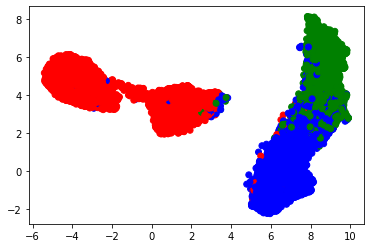

In [33]:
plt.scatter(embedding[:,0], 
            embedding[:, 1],
            c=df_all["Color"])

## Gaussian Mixture Model 

The Gaussian Mixture Model is a distribution-based clustering algorithm. It is often described as more sophisticated than k-means. It assumes that there are multiple distributions. Each distribution represents one cluster: one distribution for centre backs, one for defensive midfielders, and so on. These distributions are ultimately grouped together.


### Determine the number of clusters

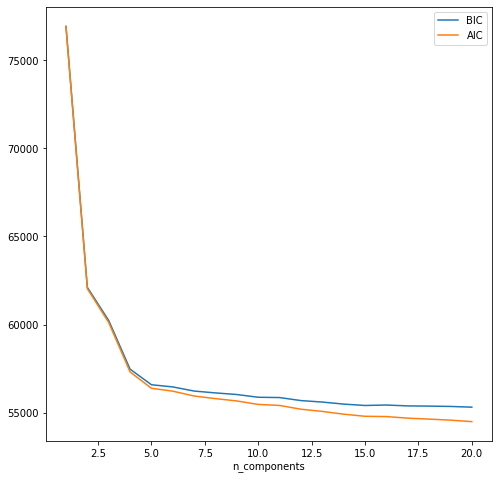

In [34]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(embedding)
          for n in n_components]

plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(embedding) for m in models], label='BIC')
plt.plot(n_components, [m.aic(embedding) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### Cluster the data

In [35]:
# Specify the number of clusters 
EM = GaussianMixture(n_components = 4, covariance_type='full')

# Perform the GMM on the UMAP dimensions
EM.fit(embedding)

# Gives me the list of clusters (hard assignment)
cluster_gmm = EM.predict(embedding)     

# Gives me the list of clusters in probabilistic terms 
cluster_p = (EM.predict_proba(embedding)).round(2)

print("Silhouette score is",silhouette_score(embedding,cluster_gmm))

Silhouette score is 0.6375201


In [36]:
# Adding the cluster and cluster probability to our dataframe
df_all["cluster_gmm"] = cluster_gmm

cluster_prob = []

for n in range(len(cluster_gmm)):
    cluster_prob.append(cluster_p[n][cluster_gmm[n]].round(2))
    
df_all["cluster_prob"] = cluster_prob

### Visualize the clusters

In [37]:
# Adding the UMAP components to the DataFrame 
umap_1 = []
for n in range(len(embedding)):
    umap_1.append(embedding[n][0])
    
umap_2 = []
for n in range(len(embedding)):
    umap_2.append(embedding[n][1])
    
df_all["umap1"] = umap_1
df_all["umap2"] = umap_2

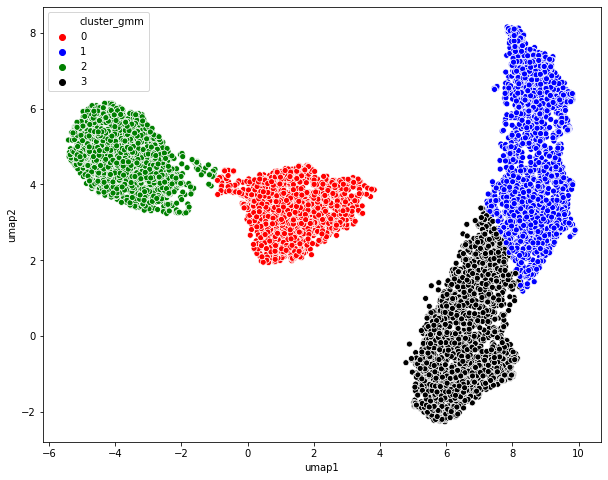

In [38]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_all,
               x="umap1",
               y="umap2",
               hue="cluster_gmm",
               palette=["red", "blue", "green", "black"])#"orange"
plt.show()

### Sanity checks

In [39]:
df_all[df_all["Squad"] == "Liverpool"][["Player", "cluster_gmm", "cluster_prob", "Age", "Season"]].head(25)

,Player,cluster_gmm,cluster_prob,Age,Season
54,Thiago Alcántara,3,1.00,31,21/22
59,Trent Alexander-Arnold,0,1.00,23,21/22
663,Virgil van Dijk,2,1.00,30,21/22
771,Fabinho,3,1.00,28,21/22
1051,Jordan Henderson,3,1.00,31,21/22
1194,Diogo Jota,1,1.00,25,21/22
1250,Naby Keïta,3,1.00,27,21/22
1498,Sadio Mané,1,1.00,30,21/22
1560,Joël Matip,2,1.00,30,21/22
2065,Andrew Robertson,0,1.00,28,21/22


In [41]:
mapping = {0:"FB", 1:"AM", 2:"CB", 3:"DM"}
df_all["cluster_gmm"] = [mapping[i] for i in df_all["cluster_gmm"]]

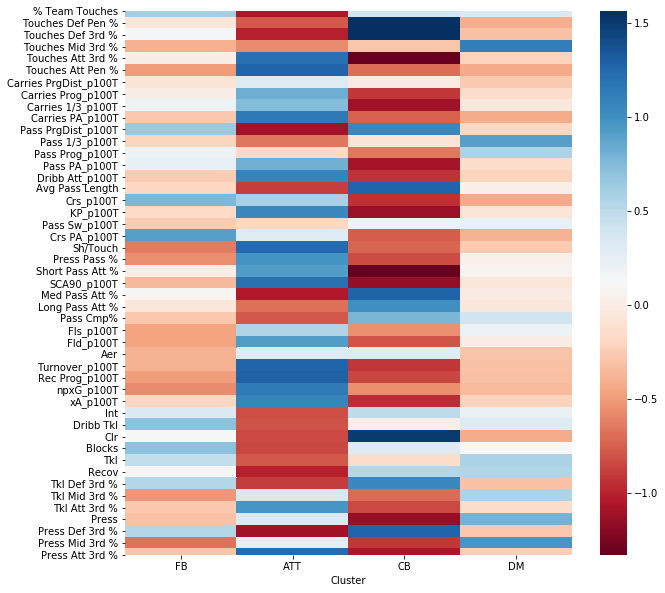

In [51]:
x_gmm = x
x_gmm["Cluster"] = cluster_gmm
x1 = x_gmm.groupby("Cluster").mean()
labels = ["FB", "ATT", "CB", "DM"]
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(x1.T, cmap="RdBu", xticklabels=labels, ax=ax) #annot=True, cbar_kws={"orientation": "vertical"}

In [54]:
df_all.to_csv("Player Clustering_22-05-06.csv", index=False)